<a href="https://colab.research.google.com/github/e-mags/ECE1512_Project_A/blob/main/MNIST1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/MyDrive/ColabNotebooks/project_a_supp')  # Change the directory to torchRay-master folder

# Requirements

In [5]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

In [6]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [7]:
from mnist1d_utils import *

# Dataset

In [8]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

In [ ]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

In [ ]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [ ]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [9]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv1D(filters=25, kernel_size=(5), padding='same', activation='relu', input_shape=(40,1), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=(3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=(3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

Printing the model's summary.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 25)            150       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10010     
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD)

Tensorboard: For recording the training procedure

In [ ]:
# Compile the model
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log', write_graph=True)

In [ ]:
model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, callbacks=[tensorboard_cb], epochs=200)

Epoch 1/200
113/113 [==============================] - 2s 12ms/step - loss: 3.6110 - accuracy: 0.1143 - val_loss: 3.4748 - val_accuracy: 0.1550
Epoch 2/200
113/113 [==============================] - 1s 5ms/step - loss: 3.4345 - accuracy: 0.1734 - val_loss: 3.4085 - val_accuracy: 0.1975
Epoch 3/200
113/113 [==============================] - 1s 6ms/step - loss: 3.3352 - accuracy: 0.2204 - val_loss: 3.3549 - val_accuracy: 0.1900
Epoch 4/200
113/113 [==============================] - 1s 5ms/step - loss: 3.2631 - accuracy: 0.2445 - val_loss: 3.2999 - val_accuracy: 0.2250
Epoch 5/200
113/113 [==============================] - 1s 6ms/step - loss: 3.2200 - accuracy: 0.2545 - val_loss: 3.2406 - val_accuracy: 0.2225
Epoch 6/200
113/113 [==============================] - 1s 6ms/step - loss: 3.1698 - accuracy: 0.2628 - val_loss: 3.2131 - val_accuracy: 0.2600
Epoch 7/200
113/113 [==============================] - 1s 6ms/step - loss: 3.0906 - accuracy: 0.3019 - val_loss: 3.1777 - val_accuracy: 0.307

Save the model

In [ ]:
model.save('MNIST1D.h5')

# Plotting the training progress

# Load the model

In [11]:
model=load_model('MNIST1D.h5')
model.summary()
model.layers[-1].get_config()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 25)            150       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10010     
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


{'activation': 'softmax',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0.0, 'seed': None, 'stddev': 0.5}},
 'kernel_regularizer': {'class_name': 'L2',
  'config': {'l2': 0.0005000000237487257}},
 'name': 'dense',
 'trainable': True,
 'units': 10,
 'use_bias': True}

Loading training progress



In [12]:
 os.listdir('log/train')[3]

'events.out.tfevents.1613100680.3250442a8b11.62.193.v2'

In [13]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[3]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Text(0.5, 1.0, 'Training progress: Accuracy')

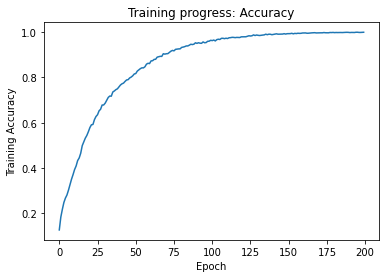

In [14]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

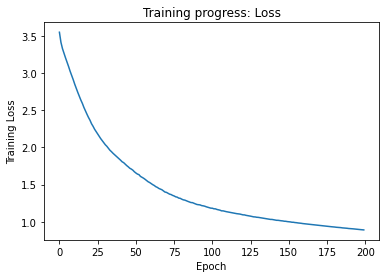

In [15]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

In [16]:
from xai_utils import *

Take a test sample

In [17]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [18]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.99999964


## SISE (Semantic Input Sampling for Explanation)

In [19]:
explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

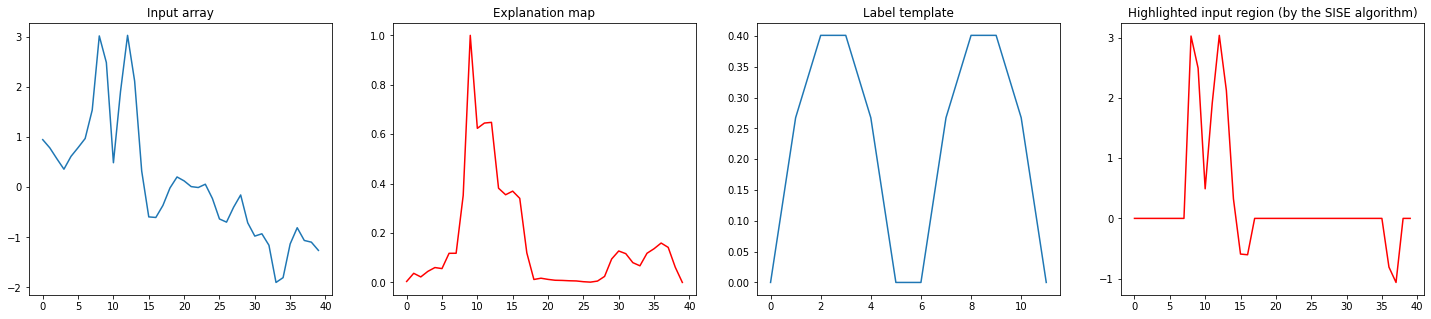

In [20]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

## Grad-CAM

In [21]:
explanation = grad_cam(model, input, 'conv1d_2')

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

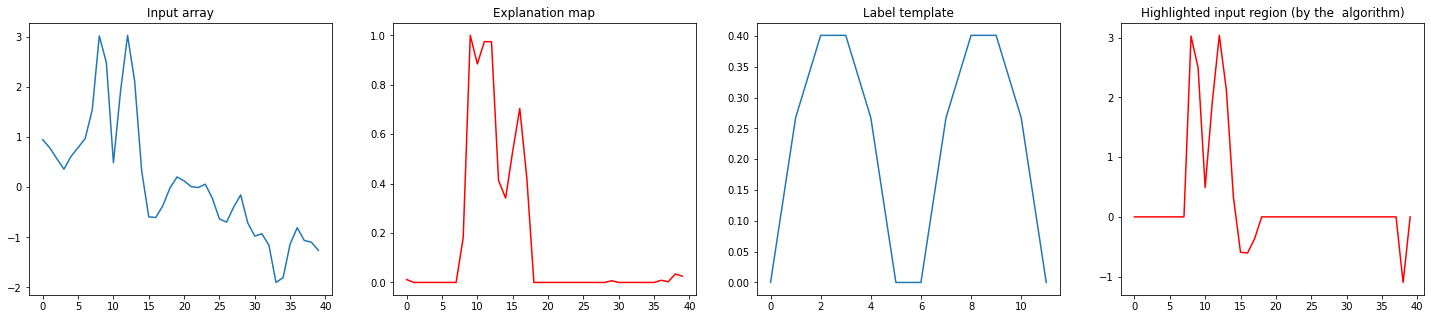

In [22]:
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

## Quantitative evaluation

In [23]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [24]:
drop_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0]
drop_rate /= 1000

## Grad-CAM++


In [31]:
import keras.layers.core
def grad_cam_pp(input_model,image,layer_name):
  cls = np.argmax(input_model.predict(image))

  y_c = input_model.output
  conv_output = input_model.get_layer(layer_name).output
  feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
  with tf.GradientTape() as tape3:
    with tf.GradientTape() as tape2:
      with tf.GradientTape() as tape1:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
      grads_val = tape1.gradient(loss, all_fmap_masks)
    second_grads = tape2.gradient(grads_val,all_fmap_masks)
  third_grads = tape3.gradient(second_grads,all_fmap_masks)
  if len(image.shape)==3:
      axis=(0, 1)
  elif len(image.shape)==4:
      axis=(0, 1, 2)
  
  weights = tf.maximum(grads_val, 0.0)

  # Alpha calculation from https://github.com/adityac94/Grad_CAM_plus_plus/blob/master/misc/utils.py
  # Calculate alpha
  global_sum = np.expand_dims(np.sum(all_fmap_masks,axis=axis),axis=axis)
  alpha_num = second_grads
  alpha_denom = 2.0 * second_grads + global_sum*third_grads
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
  alpha = alpha_num / alpha_denom

  # Normalize alpha
  alpha_thresh = np.where(weights,alpha, 0.0)
  alpha_norm_const = np.sum(alpha_thresh, axis=axis)
  alpha_norm_const_actual = np.where(alpha_norm_const != 0.0, alpha_norm_const, np.ones(alpha_norm_const.shape))
  alpha /= np.expand_dims(alpha_norm_const_actual, axis=axis)

  # Calculate weights
  weights = np.sum(weights * alpha, axis=axis)

  cam = np.dot(all_fmap_masks[0], weights)

  H,W= image.shape[1:3]
  #cam = np.maximum(cam, 0)
  #cam /= np.max(cam)

  cam = zoom(cam,H/cam.shape[0])
  cam = np.maximum(cam, 0)
  cam = cam / cam.max()
  return cam
gradcam_exp = grad_cam(model,input,'conv1d_2')
explanation = grad_cam_pp(model, input, 'conv1d_2')


Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.9999989


Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

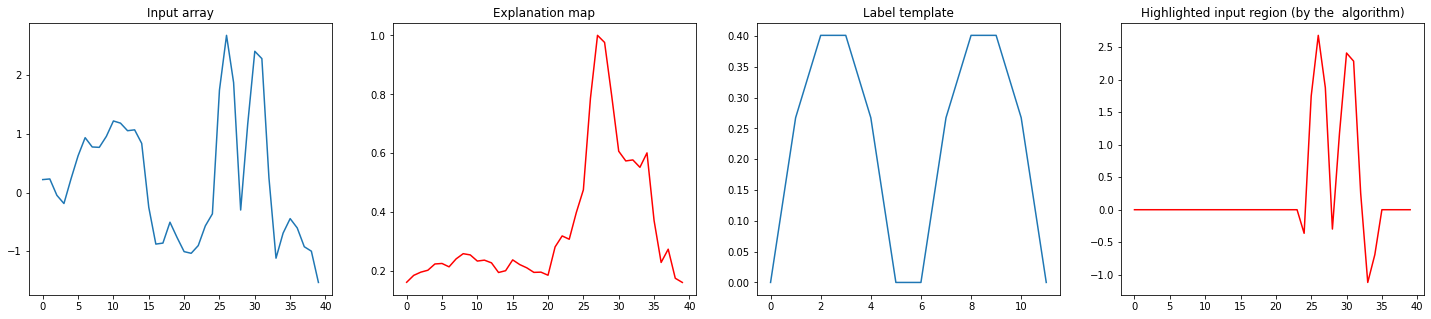

In [42]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
explanation = grad_cam_pp(model,input,'conv1d_2')
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

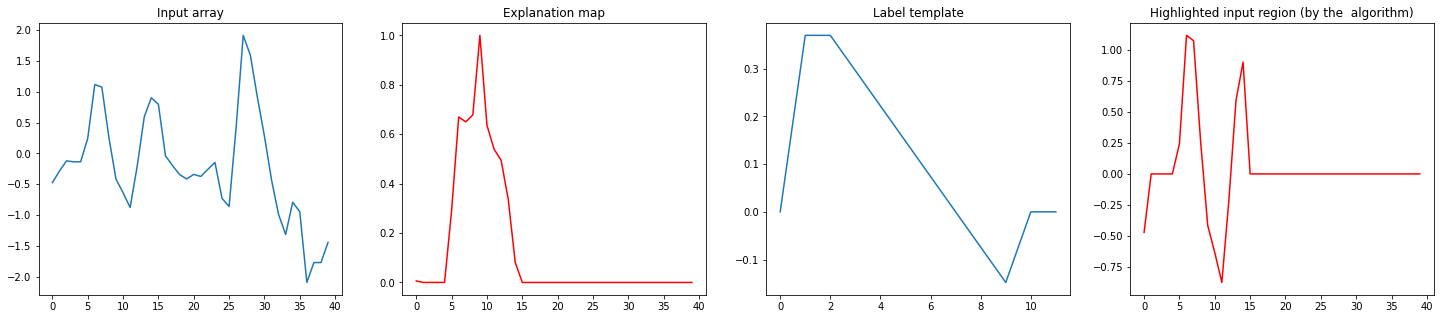

In [33]:
threshold = np.sort(gradcam_exp)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(gradcam_exp, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(gradcam_exp>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

# ROC curves and AUC

In [25]:
from sklearn import metrics
from sklearn.preprocessing import label_binarize

ROC AUC=0.991


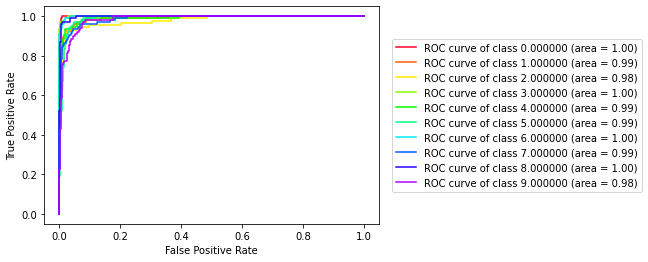

In [26]:
# Binarize y_test labels
y_test_bin = label_binarize(y_test,classes=range(10))
n_classes = y_test_bin.shape[1]

# Get predictions from model
# Predict returns softmax scores for each individual class as (1000,10) 
# with values [0,1]
y_pred = model.predict(np.expand_dims(x_test, axis=-1))

# ROC AUC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i],tpr[i],_ = metrics.roc_curve(y_test_bin[:,i],y_pred[:,i])
  roc_auc[i] = metrics.auc(fpr[i],tpr[i])

y_pred_auc = metrics.roc_auc_score(dataset['y_test'],y_pred,multi_class='ovr')

# score summary
print('ROC AUC=%.3f'%y_pred_auc)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/n_classes) for i in range(n_classes)])
for i in range(n_classes):
  ax.plot(fpr[i],tpr[i],label='ROC curve of class %f (area = %0.2f)'%(i,roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend(loc='right',bbox_to_anchor=(1.8,.5))

# Model metrics

In [34]:
x_test = dataset['x_test']
y_test = dataset['y_test']
y_test_bin = label_binarize(y_test,range(n_classes))
y_pred_frac = model.predict(np.expand_dims(x_test, axis=-1))
y_pred = np.argmax(y_pred_frac,axis=1)
y_pred_bin = label_binarize(y_pred,range(n_classes))

print('Overall accuracy:',metrics.accuracy_score(y_test,y_pred))

for i in range(n_classes):
  print('Class',i,'accuracy:',metrics.accuracy_score(y_test_bin[:,i],y_pred_bin[:,i]))

print(metrics.confusion_matrix(y_test,y_pred,labels=range(n_classes)))

scores = metrics.precision_recall_fscore_support(y_test,y_pred,average=None,labels=range(n_classes))
print(metrics.classification_report(y_test,y_pred,labels=range(10)))

Overall accuracy: 0.892
Class 0 accuracy: 0.995
Class 1 accuracy: 0.975
Class 2 accuracy: 0.973
Class 3 accuracy: 0.993
Class 4 accuracy: 0.975
Class 5 accuracy: 0.966
Class 6 accuracy: 0.989
Class 7 accuracy: 0.974
Class 8 accuracy: 0.988
Class 9 accuracy: 0.956
[[101   0   0   0   0   0   0   1   0   0]
 [  0  91   2   0   1   4   0   0   2   4]
 [  0   1  81   0   0   4   1   2   0   0]
 [  1   0   0 100   0   0   0   4   0   1]
 [  0   2   1   0  90   2   1   0   1   9]
 [  0   3   3   0   0  84   0   4   0   4]
 [  0   4   2   0   1   0  91   0   1   0]
 [  3   0   8   1   0   3   0  81   0   0]
 [  0   0   0   0   0   1   0   0  94   3]
 [  0   2   3   0   7   6   1   0   4  79]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           1       0.88      0.88      0.88       104
           2       0.81      0.91      0.86        89
           3       0.99      0.94      0.97       106
           4       0.91      0.85 